In [1]:
import torch
from networks import CRNN_2, CRNN_2_2, CRNN_2_4
import os , json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import SpectralClustering

## Import model, waights and cuda options (KNN classification)

In [2]:
#open dictionary
# dictionary_path = '/home/dlillini/apnea_detection_v3/paremters_tuning/weights_final/'+ str(exp)+'/parameters.json'
dictionary_path = '/home/dlillini/esercitazioni_2025/DACLS_apnea/apnea_detection/pretrained_weights/split2/parameters.json'

with open(dictionary_path, 'r') as file:
    dizionario = json.load(file)

ker_size = dizionario["kernel_size"]  
n_conv = dizionario["n_conv"] 
gru = dizionario["hidden_gru"]  
inp = dizionario["input"] 
print(ker_size, n_conv, gru, inp )
#Carico la rete ed i pesi
# waight_path = os.path.join('/home/dlillini/apnea_detection_v3/paremters_tuning/weights_final/',str(exp),'best_model.pth') 
waight_path = '/home/dlillini/esercitazioni_2025/DACLS_apnea/apnea_detection/pretrained_weights/split2/best_model.pth'
net = None
# define model ########################
if n_conv == 2:
    if inp == 8:
        net = CRNN_2_2(kernel_size=ker_size, pool_size1=(4,2), pool_size2=(2,2), gru=gru)
    if inp == 12:
        net = CRNN_2_2(kernel_size=ker_size, pool_size1=(4,2), pool_size2=(3,2), gru=gru)
    if inp == 18:
        net = CRNN_2_2(kernel_size=ker_size, pool_size1=(6,2), pool_size2=(2,2), gru=gru)
    if inp == 25:
        net = CRNN_2_2(kernel_size=ker_size, pool_size1=(5,2), pool_size2=(5,2), gru=gru)
    if inp == 32:
        net = CRNN_2_2(kernel_size=ker_size, pool_size1=(8,2), pool_size2=(4,2), gru=gru)
if n_conv == 3:
    if inp == 8:
        net = CRNN_2(kernel_size=ker_size, pool_size1=(2,2), pool_size2=(2,2), pool_size3=(2,2), gru=gru)
    if inp == 12:
        net = CRNN_2(kernel_size=ker_size, pool_size1=(3,2), pool_size2=(2,2), pool_size3=(2,2), gru=gru)
    if inp == 18:
        net = CRNN_2(kernel_size=ker_size, pool_size1=(4,2), pool_size2=(2,2), pool_size3=(2,2),gru=gru)
    if inp == 25:
        net = CRNN_2(kernel_size=ker_size, pool_size1=(5,2), pool_size2=(2,2), pool_size3=(2,2),gru=gru)
    if inp == 32:
        net = CRNN_2(kernel_size=ker_size, pool_size1=(8,2), pool_size2=(2,2), pool_size3=(2,2), gru=gru)
if n_conv == 4:
    if inp == 8:
        net = CRNN_2_4(kernel_size=ker_size, pool_size1=(2,2), pool_size2=(2,2), pool_size3=(2,2), pool_size4=(1,2),gru=gru)
    if inp == 12:
        net = CRNN_2_4(kernel_size=ker_size, pool_size1=(3,2), pool_size2=(2,2), pool_size3=(2,2), pool_size4=(1,2),gru=gru)
    if inp == 18:
        net = CRNN_2_4(kernel_size=ker_size, pool_size1=(2,2), pool_size2=(2,2), pool_size3=(2,2), pool_size4=(2,2),gru=gru)
    if inp == 25:
        net = CRNN_2_4(kernel_size=ker_size, pool_size1=(2,2), pool_size2=(2,2), pool_size3=(2,2), pool_size4=(3,2),gru=gru)
    if inp == 32:
        net = CRNN_2_4(kernel_size=ker_size, pool_size1=(4,2), pool_size2=(2,2), pool_size3=(2,2), pool_size4=(2,2),gru=gru)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
net.load_state_dict(torch.load(waight_path))
net.eval()


[5, 5] 4 32 12


CRNN_2_4(
  (conv1): conv_block(
    (conv): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (mpool): MaxPool2d(kernel_size=(3, 2), stride=(3, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): conv_block(
    (conv): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (mpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): conv_block(
    (conv): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (mpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): conv_bloc

### Loading data to test the net

In [3]:
def file_parse(root_dir, ext='pth'):
    a_items = []
    na_items = []
    print(f'parse {root_dir}... ', end='')
    for root, _, files in os.walk(root_dir, topdown=False):
        for name in files:
            if os.path.isfile(os.path.join(root, name)):
                if name.endswith(ext):
                    if 'apnea' in os.path.join(root, name).split('/'):
                        a_items.append(os.path.join(root, name))
                    elif 'nonapnea' in os.path.join(root, name).split('/'):
                        na_items.append(os.path.join(root, name))
    return a_items, na_items # return full path

Pazienti in training

In [4]:
root_dir = '/home/dlillini/DATA/PSG_Audio/new_split/split2/train/'
t_a_items, t_na_items = file_parse(root_dir)

parse /home/dlillini/DATA/PSG_Audio/new_split/split2/train/... 

In [5]:
#Define empty tensor to save the embeddings

t_a_emb = torch.Tensor()
t_na_emb = torch.Tensor()

#For apnea items

for mel_sp in tqdm(t_a_items):
    ap = torch.load(str(mel_sp))
    ap = ap.to(device)
    ap = ap[0:inp,:]
    with torch.no_grad():
        out_a = net((ap.unsqueeze(0).unsqueeze(0)))
    t_a_emb = torch.cat((t_a_emb,out_a.detach().cpu()))

#For non apnea items

for mel_sp in tqdm(t_na_items):
    n_ap = torch.load(str(mel_sp))
    n_ap = n_ap.to(device)
    n_ap = n_ap[0:inp,:]
    with torch.no_grad():
        out_na = net((n_ap.unsqueeze(0).unsqueeze(0)))
    t_na_emb = torch.cat((t_na_emb,out_na.detach().cpu()))

print(f'Embedded {t_a_emb.shape[0]} chunks of apnea')
print(f'Embedded {t_na_emb.shape[0]} chunks of non-apnea')


100%|██████████| 36033/36033 [00:25<00:00, 1411.69it/s]

Embedded 11789 chunks of apnea
Embedded 36033 chunks of non-apnea


Pazienti di test


In [12]:
root_dir = '/home/dlillini/DATA/PSG_Audio/new_split/split2/test/'
a_items, na_items = file_parse(root_dir)

parse /home/dlillini/DATA/PSG_Audio/new_split/split2/test/... 

In [13]:
#Define empty tensor to save the embeddings

a_emb = torch.Tensor()
na_emb = torch.Tensor()

#For apnea items

for mel_sp in tqdm(a_items):
    ap = torch.load(str(mel_sp))
    ap = ap.to(device)
    ap = ap[0:inp,:]
    with torch.no_grad():
        out_a = net((ap.unsqueeze(0).unsqueeze(0)))
    a_emb = torch.cat((a_emb,out_a.detach().cpu()))

#For non apnea items

for mel_sp in tqdm(na_items):
    n_ap = torch.load(str(mel_sp))
    n_ap = n_ap.to(device)
    n_ap = n_ap[0:inp,:]
    with torch.no_grad():
        out_na = net((n_ap.unsqueeze(0).unsqueeze(0)))
    na_emb = torch.cat((na_emb,out_na.detach().cpu()))

print(f'Embedded {a_emb.shape[0]} chunks of apnea')
print(f'Embedded {na_emb.shape[0]} chunks of non-apnea')


100%|██████████| 12473/12473 [00:07<00:00, 1685.29it/s]

Embedded 3953 chunks of apnea
Embedded 12473 chunks of non-apnea


Train

In [14]:
X_A_t = np.array(t_a_emb)
y_A_t = np.ones(X_A_t.shape[0])
X_NA_t = np.array(t_na_emb)
y_NA_t = np.zeros(X_NA_t.shape[0])
X_t = np.vstack((X_A_t, X_NA_t))
y_t= np.vstack((y_A_t[:,np.newaxis], y_NA_t[:,np.newaxis]))
y_t = np.squeeze(y_t)
print(f'X_A: {X_A_t.shape}')
print(f'X_NA: {X_NA_t.shape}')
print(f'X: {X_t.shape}')
print(f'y: {y_t.shape}')

X_A: (11789, 64)
X_NA: (36033, 64)
X: (47822, 64)
y: (47822,)


/tmp/ipykernel_121990/3508141424.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_A_t = np.array(t_a_emb)
/tmp/ipykernel_121990/3508141424.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_NA_t = np.array(t_na_emb)


test

In [15]:
X_A = np.array(a_emb)
y_A = np.ones(X_A.shape[0])
X_NA = np.array(na_emb)
y_NA = np.zeros(X_NA.shape[0])
X = np.vstack((X_A, X_NA))
y = np.vstack((y_A[:,np.newaxis], y_NA[:,np.newaxis]))
y = np.squeeze(y)
print(f'X_A: {X_A.shape}')
print(f'X_NA: {X_NA.shape}')
print(f'X: {X.shape}')
print(f'y: {y.shape}')


X_A: (3953, 64)
X_NA: (12473, 64)
X: (16426, 64)
y: (16426,)


/tmp/ipykernel_121990/4065206473.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_A = np.array(a_emb)
/tmp/ipykernel_121990/4065206473.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_NA = np.array(na_emb)


T-NSE (Dimensionality reduction from 128 to 2) need it to plot the embeddings distribution

In [12]:
# Fit T-SNE
tsne = TSNE(n_components=2, random_state=184)
X_2d = tsne.fit_transform(X)

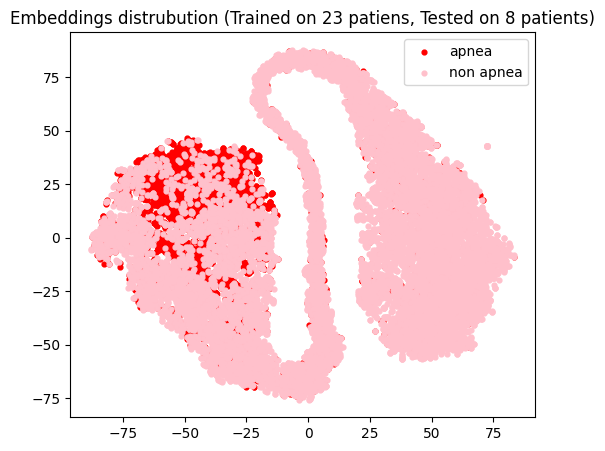

In [13]:
comment = ''
plt.figure(figsize=(6, 5))

for i, c, label, szs in zip([1,0], ['r','pink'], ['apnea','non apnea'], [12,12]):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, s=szs, label=label)
plt.legend(loc='best')
plt.title('Embeddings distrubution (Trained on 23 patiens, Tested on 8 patients)')
plt.text(0.95, 0.01, str(comment), verticalalignment='bottom', horizontalalignment='right',
         transform=plt.gca().transAxes, color='blue', fontsize=10)
plt.show()

In [16]:
# load data
lbl_apnea = 0
lbl_nonapnea = 1
y_A = lbl_apnea*np.ones(X_A.shape[0])
y_NA = lbl_nonapnea*np.ones(X_NA.shape[0])
X = np.vstack((X_A, X_NA))
y = np.vstack((y_A[:,np.newaxis], y_NA[:,np.newaxis]))
y = np.squeeze(y)
print(f'X_A: {X_A.shape}')
print(f'X_NA: {X_NA.shape}')
print(f'X: {X.shape}')
print(f'y: {y.shape}')

X_A: (3953, 64)
X_NA: (12473, 64)
X: (16426, 64)
y: (16426,)


FIT su train

In [17]:
# K-means clustering
import time
np.random.seed(5)
estimator = KMeans(n_clusters=2)

start_time = time.time()
estimator.fit(X_t)
labels_pred = estimator.predict(X)
end_time = time.time()

accuracy = ((labels_pred==y).sum() / len(y))
rec = recall_score(y,labels_pred, average='binary')
prec = precision_score(y,labels_pred, average='binary')
print(f'Accuracy: {accuracy}')
print(f'Recall: {rec}')
print(f'Precision: {prec}')
print(f'Time: {end_time-start_time}')

Accuracy: 0.8746499452088153
Recall: 0.9126914134530586
Precision: 0.9214829205115752
Time: 0.014730453491210938
